-------------
### ライブラリのインポート

In [1]:
# 基本的なライブラリ
import numpy as np
import pandas as pd
from numpy.typing import NDArray
from scipy import stats

# タイピングのサポート
from typing import Optional

# 可視化の設定
import matplotlib.pyplot as plt
import japanize_matplotlib
import itertools

plt.style.use("ggplot")

--------------
### 辞書作成

実験設定

In [2]:
TARGET = "BCR"
SAMPLE_SIZE = 10000

if TARGET == "GMV":
    X_LIM_VAR = 300000
    X_LIM_REDUC = 30
if TARGET == "BCR":
    X_LIM_VAR = 0.003
    X_LIM_REDUC = 30
if TARGET == "PM2.5":
    X_LIM_VAR = 0.5
    X_LIM_REDUC = 20
if TARGET == "Visit":
    X_LIM_VAR = 0.000005
    X_LIM_REDUC = 80

各ファイルからコピペ

In [3]:
var_random_train = 2.2378598307100002e-05
var_random_test = 2.2339442044400003e-05

var_sep_dict_train = {
    "Kmeans": {
        "Proportional": 2.0116403518428847e-05,
        "Post": 2.0368106552168922e-05,
        "Optimal": 2.0173874111217573e-05,
    },
    "Lasso-Kmeans": {
        "Proportional": 1.88674137831985e-05,
        "Post": 1.8816306366720168e-05,
        "Optimal": 1.8773117797302408e-05,
    },
    "SFS-Kmeans-F": {
        "Proportional": 2.0939119878300538e-05,
        "Post": 2.1386070183828955e-05,
        "Optimal": 2.1701103980545834e-05,
    },
    "SFS-Kmeans-T": {
        "Proportional": 1.8625748007337906e-05,
        "Post": 1.8627587219524474e-05,
        "Optimal": 1.865319741584823e-05,
    },
}
var_sep_dict_test = {
    "Kmeans": {
        "Proportional": 2.0082189143105084e-05,
        "Post": 2.0787227046272794e-05,
        "Optimal": 1.9924247551387674e-05,
    },
    "Lasso-Kmeans": {
        "Proportional": 1.924483662803489e-05,
        "Post": 1.9091267324211975e-05,
        "Optimal": 1.888334394583276e-05,
    },
    "SFS-Kmeans-F": {
        "Proportional": 2.1464633769651332e-05,
        "Post": 2.083717758696282e-05,
        "Optimal": 2.0870643923261207e-05,
    },
    "SFS-Kmeans-T": {
        "Proportional": 1.8900978892636727e-05,
        "Post": 1.8439059213778386e-05,
        "Optimal": 1.8752517802814216e-05,
    },
}


var_once_dict_train = {
    "Proportional": 1.8755062087975365e-05,
    "Post": 1.8804507476072617e-05,
    "Optimal": 1.852475871835286e-05,
}
var_once_dict_test = {
    "Proportional": 1.9309563397997896e-05,
    "Post": 1.9309701794270616e-05,
    "Optimal": 1.836958159177842e-05,
}


var_cuped_train = 1.897115744869332e-05
var_cuped_test = 1.911270538693194e-05

var_coss_train = 2.036832599640001e-05
var_coss_test = 2.0924232179900006e-05


分散削減率の計算

In [4]:
reduc_sep_dict_train = {}
reduc_sep_dict_test = {}
for method, d in var_sep_dict_train.items():
    reduc_sep_dict_train[method] = {}
    for allo, var in d.items():
        reduc_sep_dict_train[method][allo] = (1 - var / var_random_train) * 100
for method, d in var_sep_dict_test.items():
    reduc_sep_dict_test[method] = {}
    for allo, var in d.items():
        reduc_sep_dict_test[method][allo] = (1 - var / var_random_test) * 100

reduc_once_dict_train = {}
reduc_once_dict_test = {}
for allo, var in var_once_dict_train.items():
    reduc_once_dict_train[allo] = (1 - var / var_random_train) * 100
for allo, var in var_once_dict_test.items():
    reduc_once_dict_test[allo] = (1 - var / var_random_test) * 100

reduc_cuped_train = (1 - var_cuped_train / var_random_train) * 100
reduc_cuped_test = (1 - var_cuped_test / var_random_test) * 100

In [5]:
def make_var_dict(
    var_random: float,
    var_cuped: float,
    var_sep_dict: dict[str, dict[str, float]],
    var_once_dict: dict[str, float],
) -> dict:
    var_dict = {"Random": var_random, "CUPED": var_cuped}
    for method, _ in var_sep_dict.items():
        var_dict[method] = {
            "Optimal": var_sep_dict[method]["Optimal"],
            "Post": var_sep_dict[method]["Post"],
            "Proportional": var_sep_dict[method]["Proportional"],
        }
    var_dict["SFS-Kmeans-Var"] = {
        "Optimal": var_once_dict["Optimal"],
        "Post": var_once_dict["Post"],
        "Proportional": var_once_dict["Proportional"],
    }

    return var_dict


def make_reduc_dict(
    reduc_cuped: float,
    reduc_sep_dict: dict[str, dict[str, float]],
    reduc_once_dict: dict[str, float],
) -> dict:
    reduc_dict = {"CUPED": reduc_cuped}
    for method, _ in reduc_sep_dict.items():
        reduc_dict[method] = {
            "Optimal": reduc_sep_dict[method]["Optimal"],
            "Post": reduc_sep_dict[method]["Post"],
            "Proportional": reduc_sep_dict[method]["Proportional"],
        }
    reduc_dict["SFS-Kmeans-Var"] = {
        "Optimal": reduc_once_dict["Optimal"],
        "Post": reduc_once_dict["Post"],
        "Proportional": reduc_once_dict["Proportional"],
    }

    return reduc_dict

In [6]:
var_dict_train = make_var_dict(
    var_random=var_random_train,
    var_cuped=var_cuped_train,
    var_sep_dict=var_sep_dict_train,
    var_once_dict=var_once_dict_train,
)
var_dict_test = make_var_dict(
    var_random=var_random_test,
    var_cuped=var_cuped_test,
    var_sep_dict=var_sep_dict_test,
    var_once_dict=var_once_dict_test,
)

reduc_dict_train = make_reduc_dict(
    reduc_cuped=reduc_cuped_train,
    reduc_sep_dict=reduc_sep_dict_train,
    reduc_once_dict=reduc_once_dict_train,
)
reduc_dict_test = make_reduc_dict(
    reduc_cuped=reduc_cuped_test,
    reduc_sep_dict=reduc_sep_dict_test,
    reduc_once_dict=reduc_once_dict_test,
)

-----------
### 可視化

分散

訓練データの結果


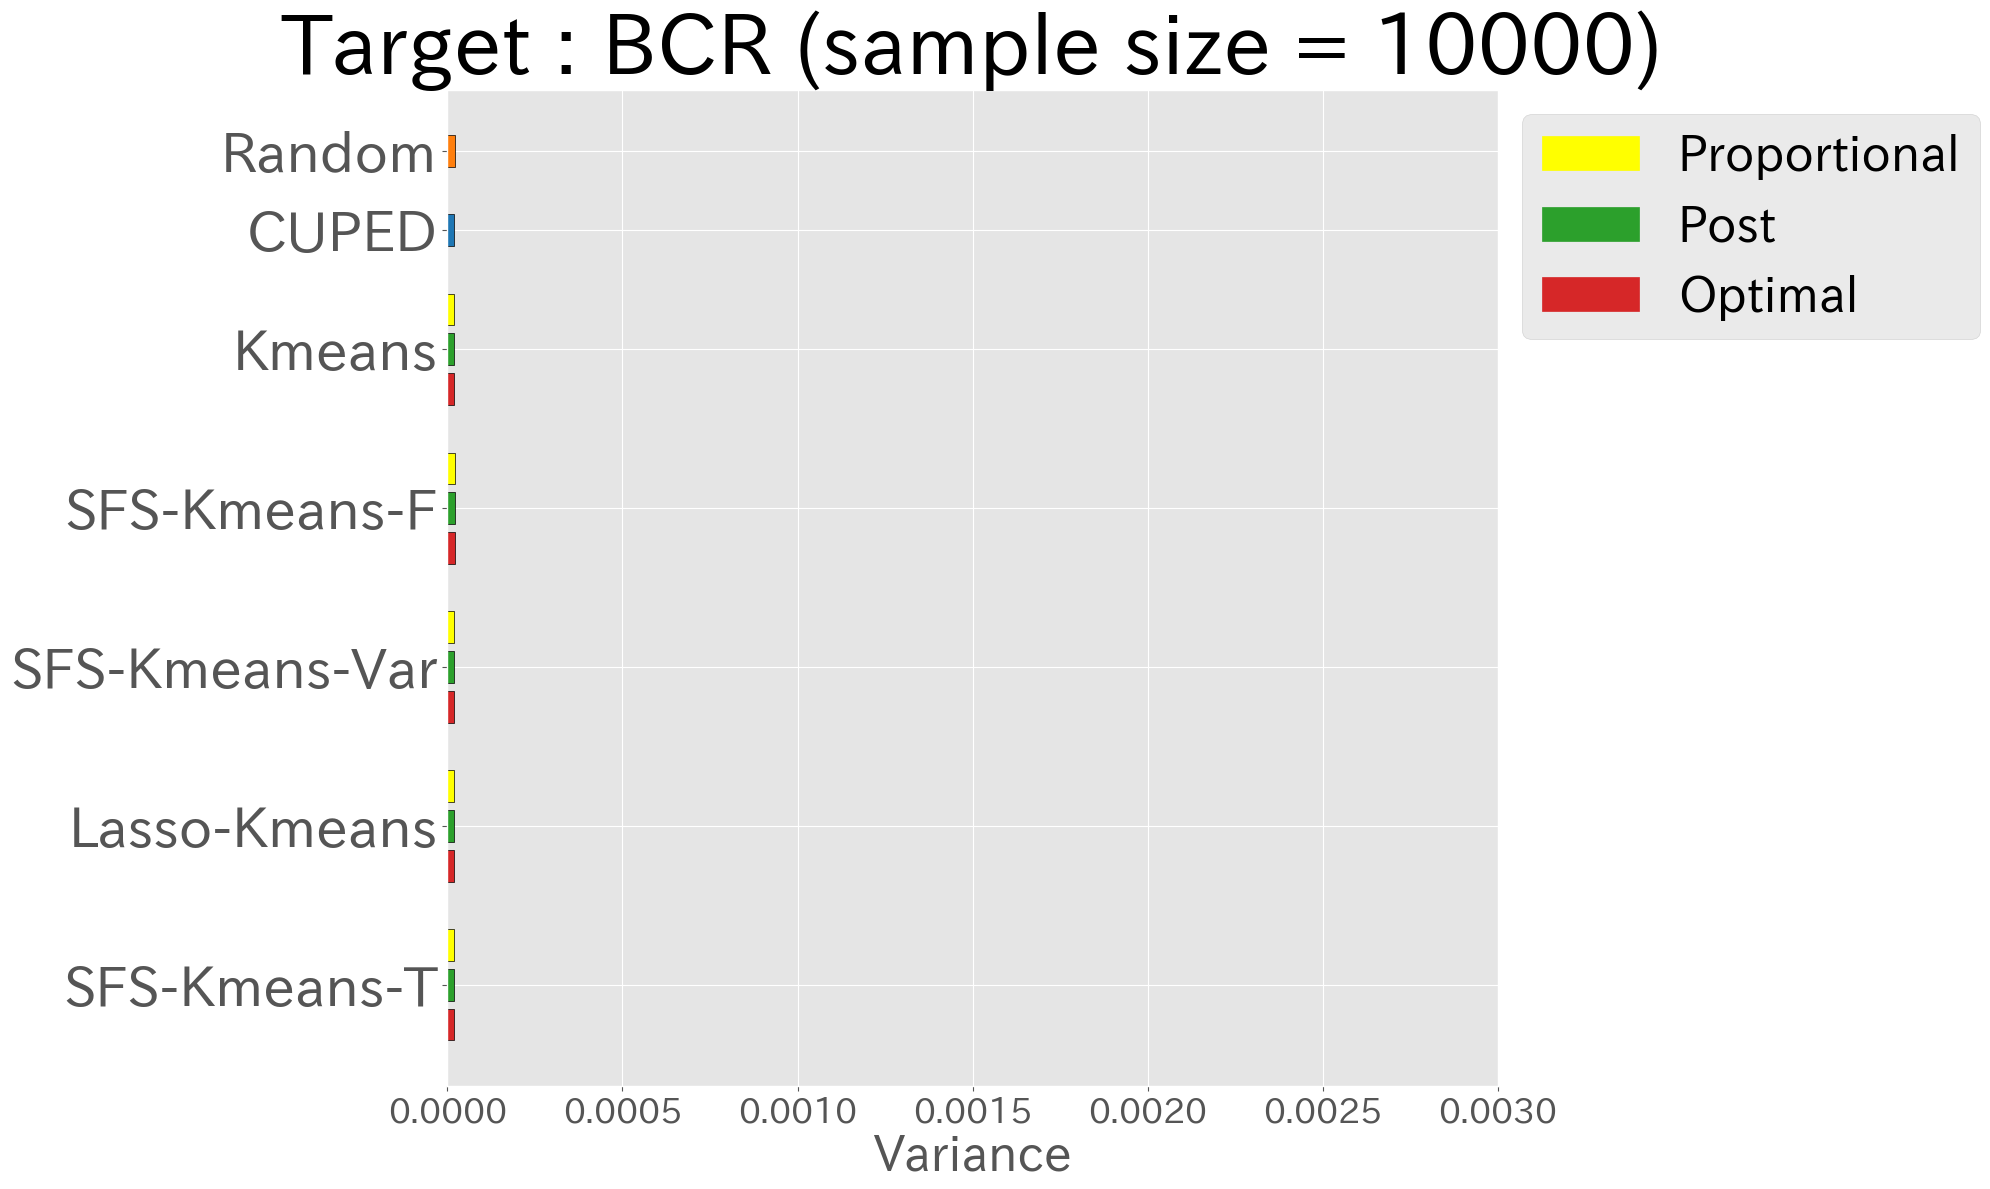

テストデータの結果


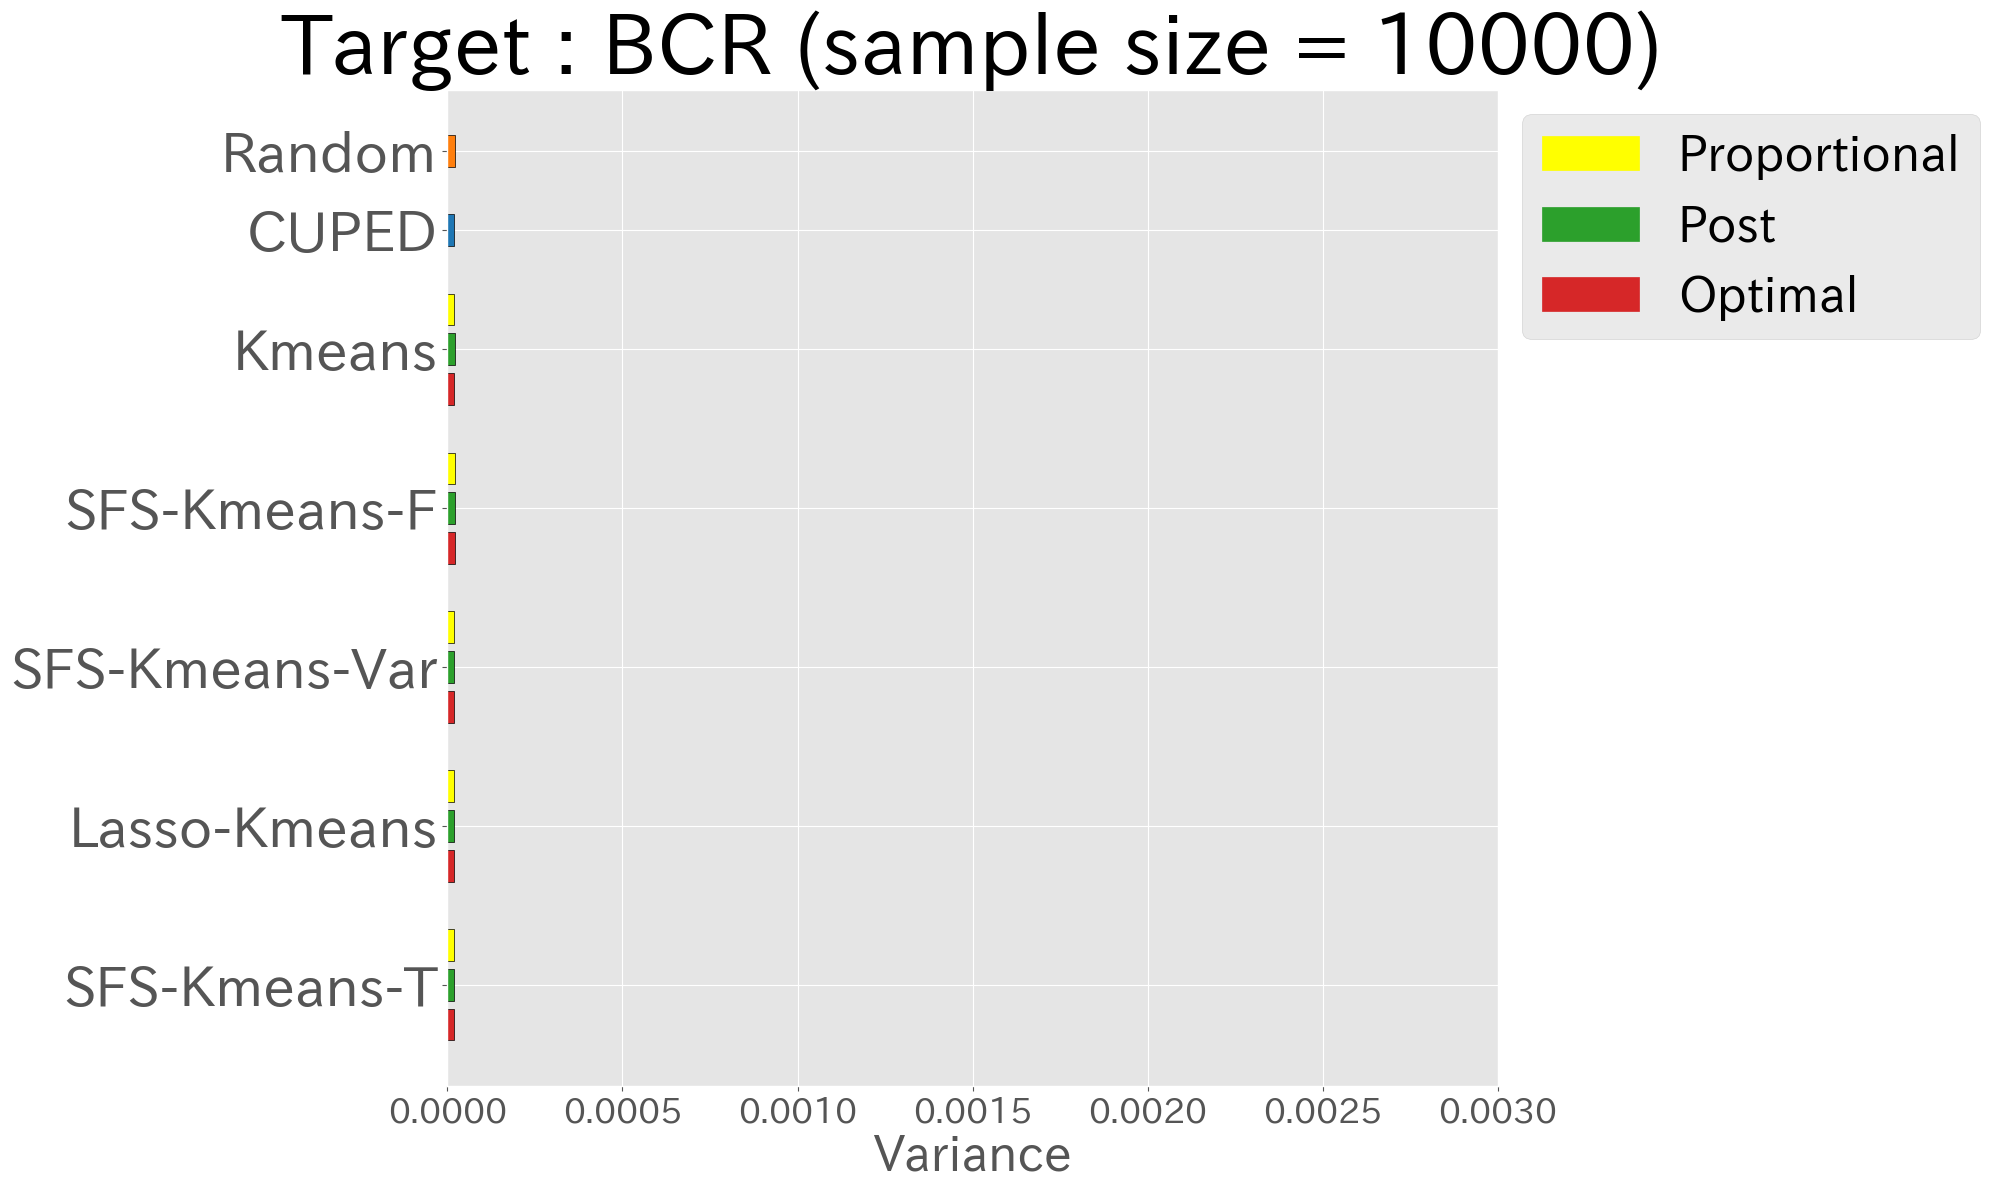

In [7]:
for var_dict in [var_dict_train, var_dict_test]:
    if var_dict == var_dict_train:
        print("訓練データの結果")
    if var_dict == var_dict_test:
        print("テストデータの結果")
    # グラフ用データを準備
    labels = [
        "SFS-Kmeans-T",
        "Lasso-Kmeans",
        "SFS-Kmeans-Var",
        "SFS-Kmeans-F",
        "Kmeans",
        "CUPED",
        "Random",
    ]

    values = (
        list(var_dict["SFS-Kmeans-T"].values())
        + [0]
        + list(var_dict["Lasso-Kmeans"].values())
        + [0]
        + list(var_dict["SFS-Kmeans-Var"].values())
        + [0]
        + list(var_dict["SFS-Kmeans-F"].values())
        + [0]
        + list(var_dict["Kmeans"].values())
        + [0]
        + [var_dict["CUPED"]]
        + [0]
        + [var_dict["Random"]]
    )

    # 各グループに色を割り当て、間隔には透明な色を使用
    colors = (
        ["#d62728", "#2ca02c", "#FFFF00"]
        + ["#FFFFFF00"]
        + ["#d62728", "#2ca02c", "#FFFF00"]
        + ["#FFFFFF00"]
        + ["#d62728", "#2ca02c", "#FFFF00"]
        + ["#FFFFFF00"]
        + ["#d62728", "#2ca02c", "#FFFF00"]
        + ["#FFFFFF00"]
        + ["#d62728", "#2ca02c", "#FFFF00"]
        + ["#FFFFFF00"]
        + ["#1f77b4"]
        + ["#FFFFFF00"]
        + ["#ff7f0e"]
    )

    # 各ラベルが3つの棒の真ん中に配置されるように位置を調整
    y_positions = [1, 5, 9, 13, 17, 20, 22]

    # グラフを描画
    fig, ax = plt.subplots(figsize=(20, 12))
    ax.barh(range(len(values)), values, color=colors, edgecolor="black")

    # 凡例の追加
    legend_labels = ["Proportional", "Post", "Optimal"]
    # 色のリスト
    legend_colors = ["#FFFF00", "#2ca02c", "#d62728"]
    # 各ラベルに対してハンドルを作成
    handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in legend_colors]
    ax.legend(
        handles, legend_labels, fontsize=35, loc="upper left", bbox_to_anchor=(1, 1)
    )

    # y軸の目盛りとラベルを設定
    ax.set_yticks(y_positions)
    ax.tick_params(axis="x", labelsize=25)
    ax.set_yticklabels(labels, fontsize=40)
    ax.set_xlabel("Variance", fontsize=35)
    ax.set_title(f"Target : {TARGET} (sample size = {SAMPLE_SIZE})", fontsize=60)
    ax.set_xlim(0, X_LIM_VAR)
    plt.tight_layout()
    plt.show()

削減率

訓練データの結果


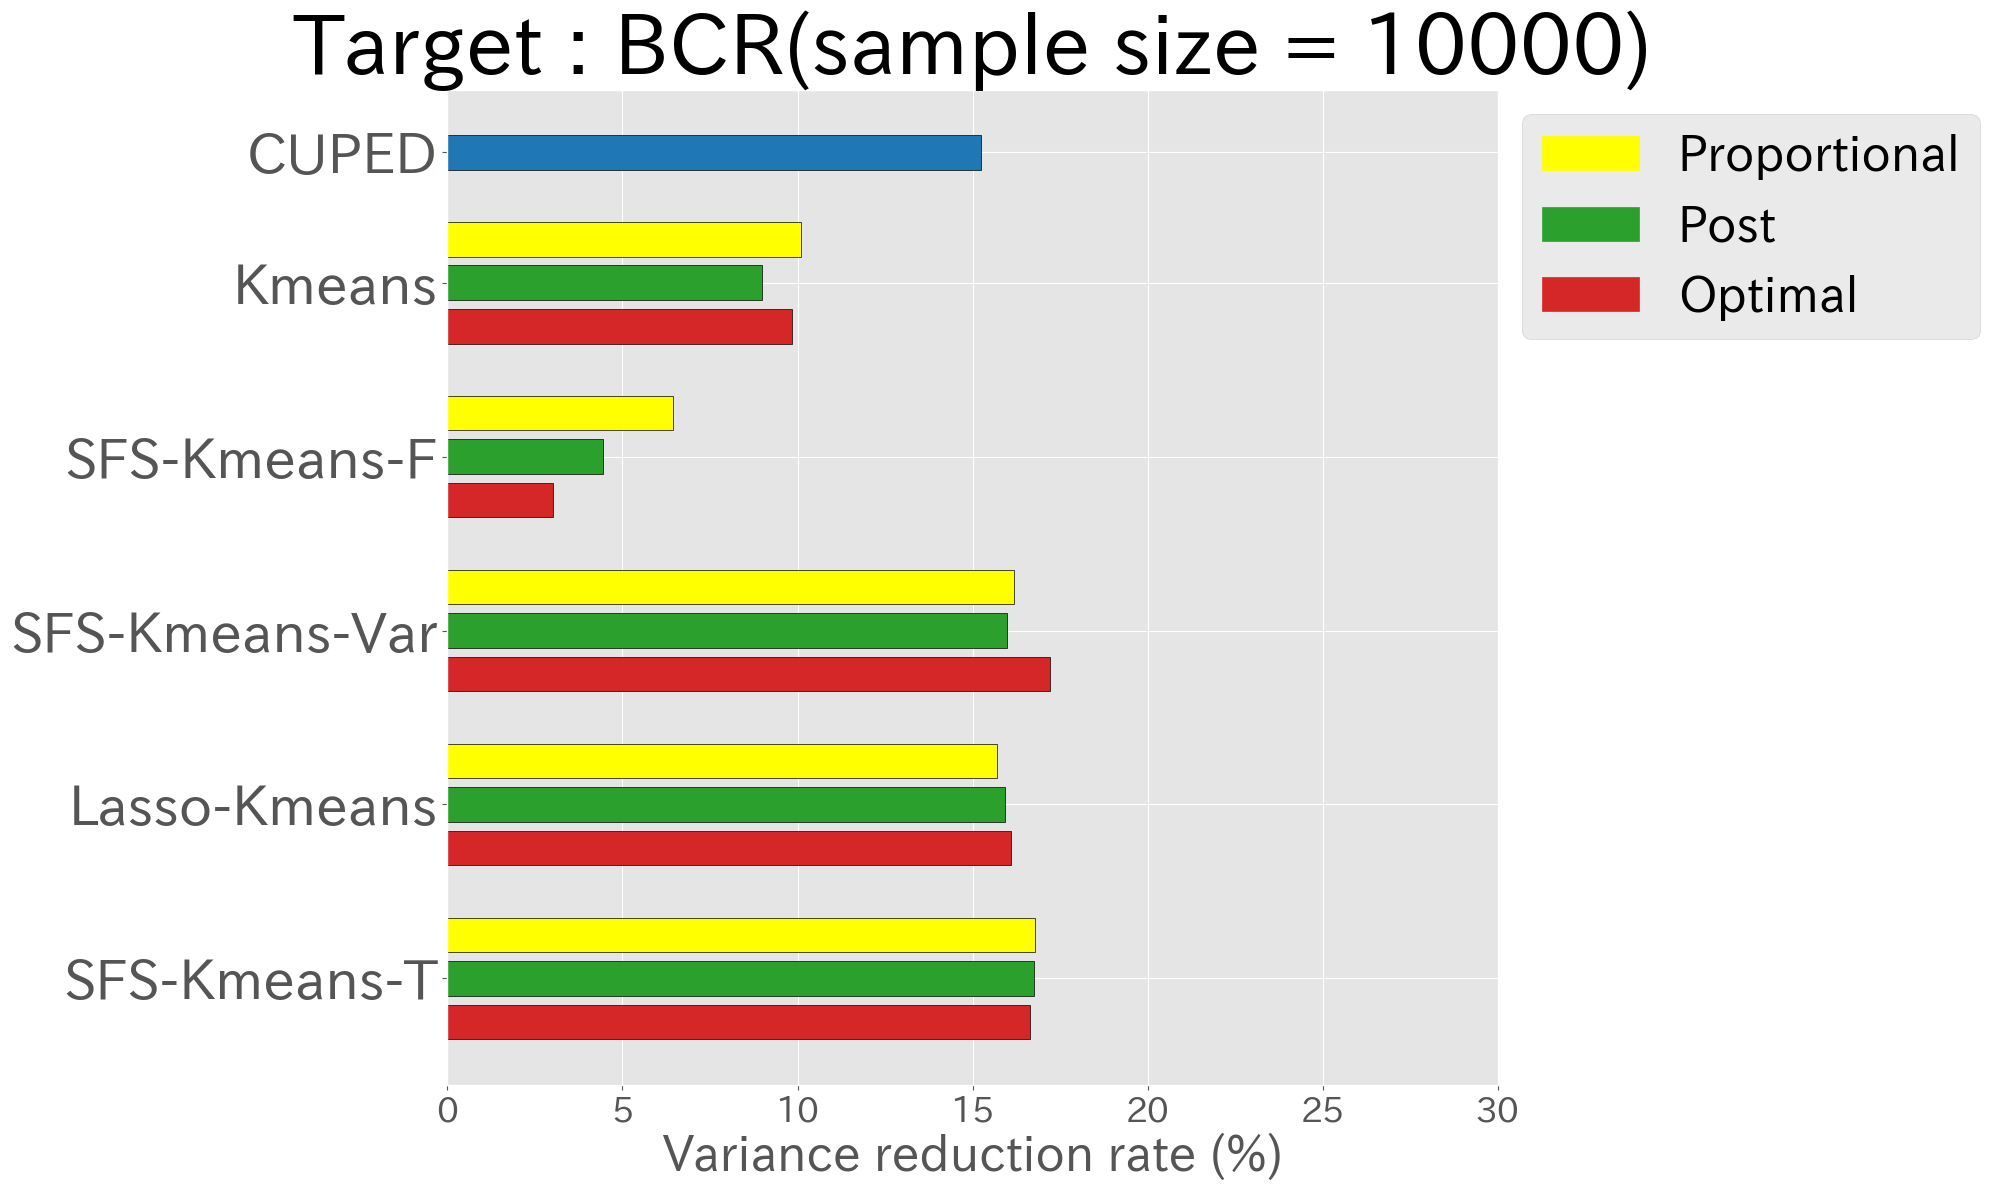

テストデータの結果


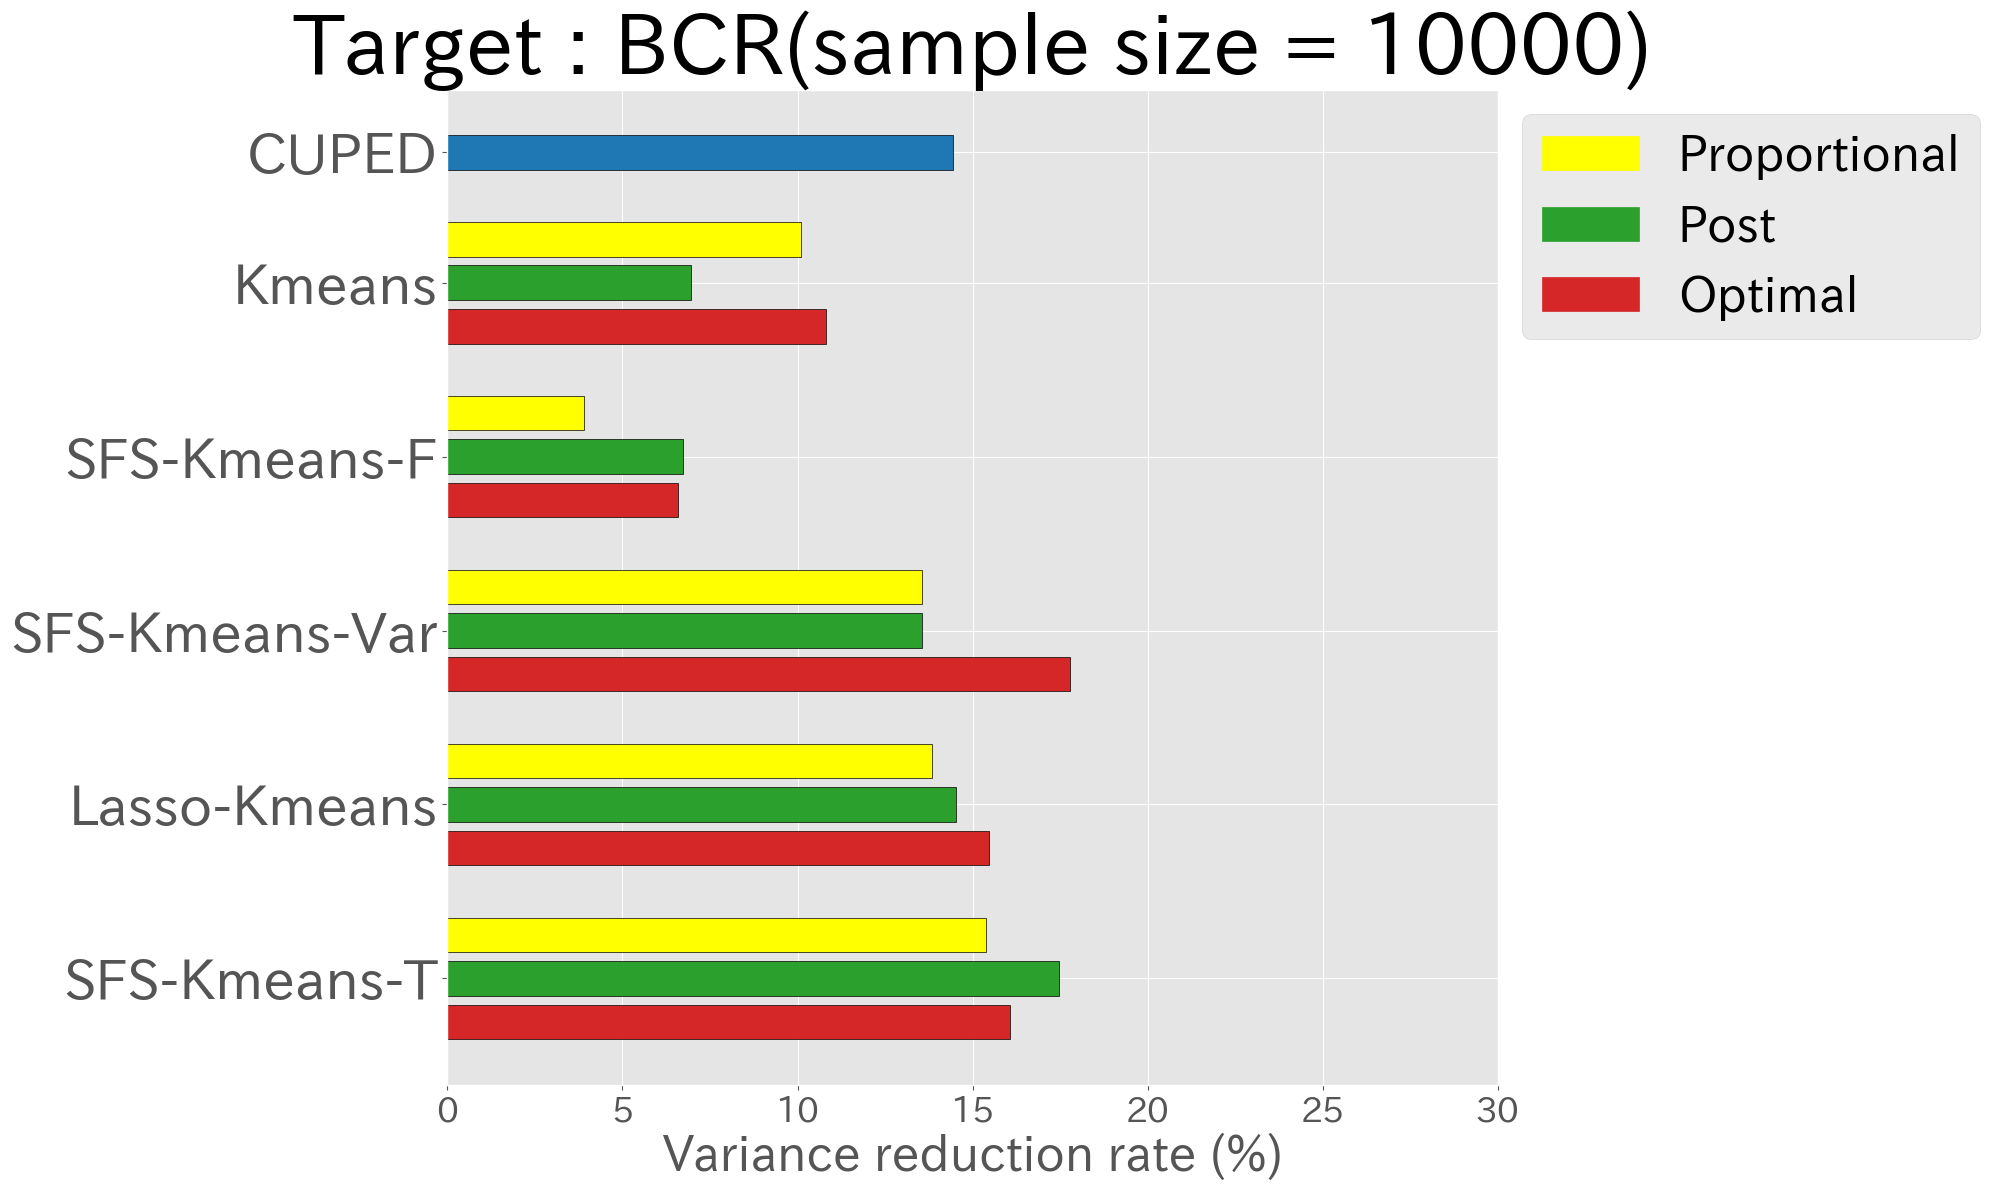

In [8]:
for reduc_dict in [reduc_dict_train, reduc_dict_test]:
    if reduc_dict == reduc_dict_train:
        print("訓練データの結果")
    if reduc_dict == reduc_dict_test:
        print("テストデータの結果")

    # グラフ用データを準備
    labels = [
        "SFS-Kmeans-T",
        "Lasso-Kmeans",
        "SFS-Kmeans-Var",
        "SFS-Kmeans-F",
        "Kmeans",
        "CUPED",
    ]
    values = (
        list(reduc_dict["SFS-Kmeans-T"].values())
        + [0]
        + list(reduc_dict["Lasso-Kmeans"].values())
        + [0]
        + list(reduc_dict["SFS-Kmeans-Var"].values())
        + [0]
        + list(reduc_dict["SFS-Kmeans-F"].values())
        + [0]
        + list(reduc_dict["Kmeans"].values())
        + [0]
        + [reduc_dict["CUPED"]]
    )

    # 各グループに色を割り当て、間隔には透明な色を使用
    colors = (
        ["#d62728", "#2ca02c", "#FFFF00"]
        + ["#FFFFFF00"]
        + ["#d62728", "#2ca02c", "#FFFF00"]
        + ["#FFFFFF00"]
        + ["#d62728", "#2ca02c", "#FFFF00"]
        + ["#FFFFFF00"]
        + ["#d62728", "#2ca02c", "#FFFF00"]
        + ["#FFFFFF00"]
        + ["#d62728", "#2ca02c", "#FFFF00"]
        + ["#FFFFFF00"]
        + ["#1f77b4"]
    )

    # 各ラベルが3つの棒の真ん中に配置されるように位置を調整
    y_positions = [1, 5, 9, 13, 17, 20]

    # グラフを描画
    fig, ax = plt.subplots(figsize=(20, 12))
    ax.barh(range(len(values)), values, color=colors, edgecolor="black")

    # 凡例の追加
    legend_labels = ["Proportional", "Post", "Optimal"]
    # 色のリスト
    legend_colors = ["#FFFF00", "#2ca02c", "#d62728"]
    # 各ラベルに対してハンドルを作成
    handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in legend_colors]
    ax.legend(
        handles, legend_labels, fontsize=35, loc="upper left", bbox_to_anchor=(1, 1)
    )

    # y軸の目盛りとラベルを設定
    ax.set_yticks(y_positions)
    ax.tick_params(axis="x", labelsize=25)
    ax.set_yticklabels(labels, fontsize=40)
    ax.set_xlabel("Variance reduction rate (%)", fontsize=35)
    ax.set_title(f"Target : {TARGET}(sample size = {SAMPLE_SIZE})", fontsize=60)
    ax.set_xlim(0, X_LIM_REDUC)
    plt.tight_layout()
    plt.show()